<a href="https://colab.research.google.com/github/ksulaiman1/SIFT-Features-Image-Classification/blob/main/sift_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [164]:
import os
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import itertools
import shutil
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report
# from pyimagesearch import simplepreprocessor
# from pyimagesearch import simpledatasetloader
from imutils import paths

import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score

In [3]:
%cd /content/drive/MyDrive/cropped_plants

/content/drive/MyDrive/cropped_plants


In [4]:
train_data = []
for img in glob.glob('banana/*.png'):
  train_data.append((img,0))

for img in glob.glob('cassava/*.png'):
  train_data.append((img, 1))

In [5]:
train_data = pd.DataFrame(train_data, columns=['plant', 'label'],index=None)


In [ ]:
train_data['label'].value_counts()

1    914
0    893
Name: label, dtype: int64

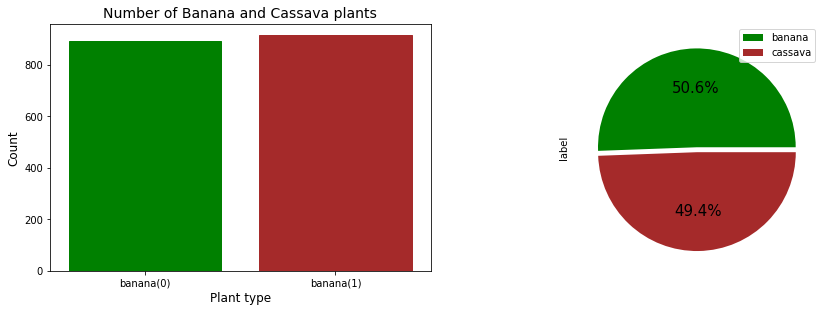

In [ ]:
plant_count = train_data['label'].value_counts()
# Plot the results 
plt.figure(figsize=(15,10))
plt.subplot(221)
ax = sns.barplot(x=plant_count.index, y= plant_count.values)
plt.title('Number of Banana and Cassava plants', fontsize=14)
plt.xlabel('Plant type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(plant_count.index)), ['banana(0)', 'banana(1)'])

ax.patches[0].set_color('green')
ax.patches[1].set_color('brown')

plt.subplot(222)
train_data['label'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['green','brown'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['banana', 'cassava'])
plt.show()

In [6]:
cassava_samples = (train_data[train_data['label']==1]['plant'].iloc[:5]).tolist()
banana_samples = (train_data[train_data['label']==0]['plant'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = banana_samples + cassava_samples

In [ ]:
samples

['banana/banana_122.png',
 'banana/banana_135.png',
 'banana/banana_54.png',
 'banana/banana_108.png',
 'banana/banana_58.png',
 'cassava/cassava_6.png',
 'cassava/cassava_38.png',
 'cassava/cassava_25.png',
 'cassava/cassava_18.png',
 'cassava/cassava_10.png']

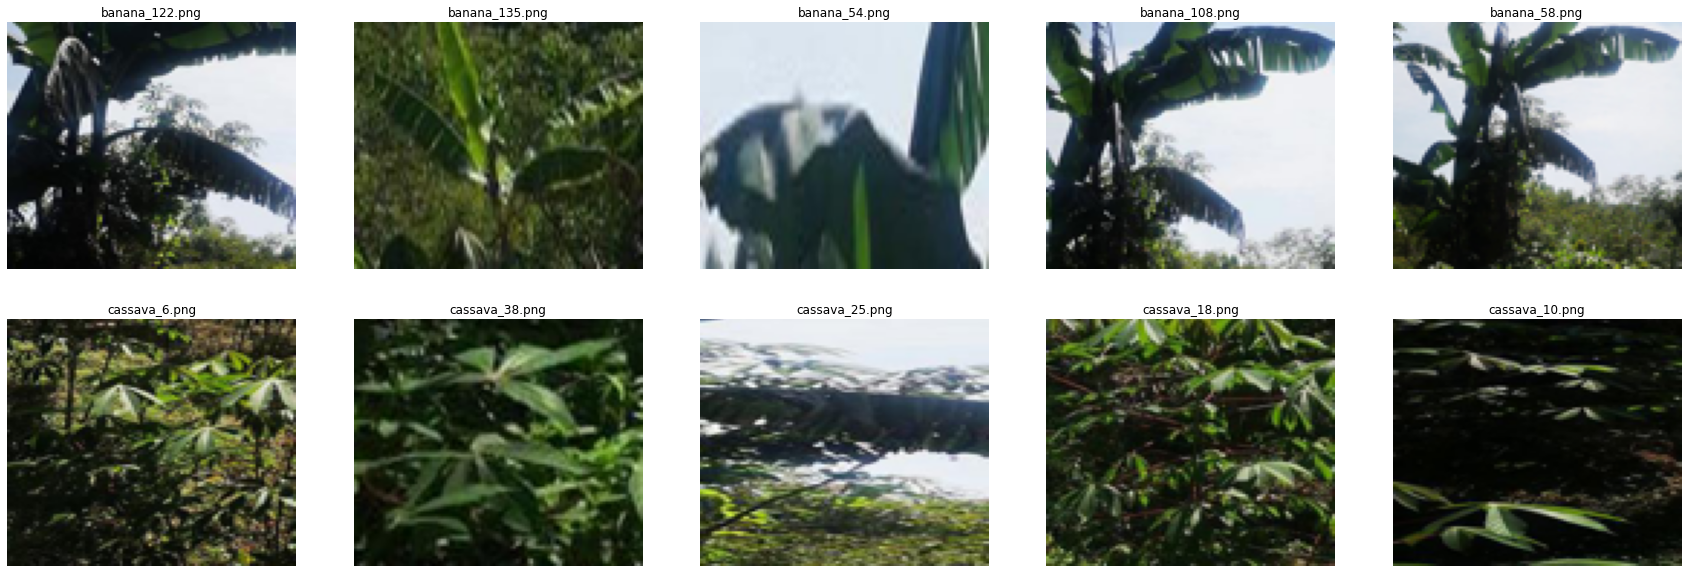

In [ ]:
# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = Image.open(samples[i])
    ax[i//5, i%5].imshow(img)
    if i<5:
        ax[i//5, i%5].set_title(samples[i].split("/")[1])
    else:
        ax[i//5, i%5].set_title(samples[i].split("/")[1])
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:
train_set, test_set = train_test_split(train_data, test_size=0.3, random_state=0, stratify=train_data.label)
# train_set, test_set = train_test_split(train_set, test_size=0.2, random_state=0, stratify=train_set.label)

In [ ]:
train_set.shape, test_set.shape

((1264, 2), (543, 2))

In [ ]:
train_set['label'].value_counts()

1    639
0    625
Name: label, dtype: int64

In [ ]:
test_set['label'].value_counts()

1    275
0    268
Name: label, dtype: int64

In [ ]:
# os.makedirs('train/banana')
# os.makedirs('train/cassava')
# os.makedirs('test/banana')
# os.makedirs('test/cassava')

In [ ]:
# train_banana = 'train/banana'
# train_cassava = 'train/cassava'

# test_banana = 'test/banana'
# test_cassava = 'test/cassava'

In [7]:
# for img in tqdm(train_set[train_set['label']==0]['plant'], 'Copying train banana images: '):
#   shutil.copy(img, train_banana)

# for img in tqdm(train_set[train_set['label']==1]['plant'], 'Copying train cassava images: '):
#   shutil.copy(img, train_cassava)


# for img in tqdm(test_set[test_set['label']==0]['plant'], 'Copying test banana images: '):
#   shutil.copy(img, test_banana)

# for img in tqdm(test_set[test_set['label']==1]['plant'], 'Copying test cassava images: '):
#   shutil.copy(img, test_cassava)

In [8]:
!ls

all						  test	 Untitled2.ipynb
resize_and_write_images_inside_same_folder.ipynb  train


In [9]:
path = 'all'
image_path = []
for file in os.listdir(path):
  dir = os.path.join(path, file)
  for file in os.listdir(dir):
    image_path.append(os.path.join(dir, file))

In [10]:
len(image_path)

1807

In [11]:
def CalcFeatures(img):
  sift = cv2.SIFT_create()
  kp, des = sift.detectAndCompute(img, None)
  return des


In [12]:
features = []
for file in image_path:
  img = cv2.imread(file, 0)
  img_des = CalcFeatures(img)
  if img_des is not None:
    features.append(img_des)


features = np.vstack(features)

In [13]:
features.shape

(209171, 128)

In [ ]:
k = 200
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

In [188]:
centres.shape

(200, 128)

In [187]:
def bag_of_features(features, centres, k):
    vec = np.zeros((1, k))
    for i in range(features.shape[0]):
        feat = features[i]
        diff = np.tile(feat, (k, 1)) - centres
        dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
        idx_dist = dist.argsort()
        idx = idx_dist[0]
        vec[0][idx] += 1
    return vec

In [189]:
labels = []
vec = []
for file in image_path:
  img = cv2.imread(file, 0)
  img_desc = CalcFeatures(img)
  if img_desc is not None:
    img_vec = bag_of_features(img_desc, centres, k)
    vec.append(img_vec)
    labels.append(file.split('/')[1])
vec = np.vstack(vec)

In [173]:
vec.shape

(1807, 150)

In [174]:
labels = LabelEncoder().fit_transform(labels)

In [175]:
labels.shape

(1807,)

In [176]:
vec = StandardScaler().fit_transform(vec)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.3, random_state=0, stratify=labels)

In [178]:
X_train.shape, X_test.shape

((1264, 150), (543, 150))

In [179]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [180]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
nb = GaussianNB()

In [181]:
knn.fit(X_train, y_train)
nb.fit(X_train, y_train)

GaussianNB()

In [182]:
knn_pred = knn.predict(X_test)
nb_pred = nb.predict(X_test)

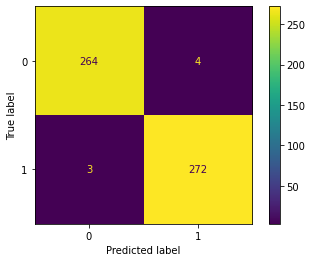

In [183]:
cm = confusion_matrix(y_test, knn_pred)
ConfusionMatrixDisplay(cm).plot()

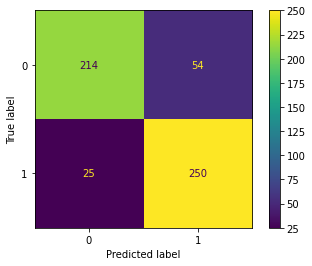

In [184]:
cm = confusion_matrix(y_test, nb_pred)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
# for count, file_name in enumerate(os.listdir('banana')):
#     os.rename(f'banana/{file_name}', 'cassava_'+str(count)+'.jpg')

In [ ]:
# cassava = []
# for img in glob.glob('cassava/*.png'):
#     cassava.append(img)
    
# path  = 'cassava'

# for filename in cassava :
#     img = Image.open(filename).resize((100,100))
#     img.save(filename)

In [ ]:
# for count, file_name in enumerate(os.listdir('cassava')):
#     os.rename(f'cassava/{file_name}', f'cassava_{str(count)}.png')

In [ ]:
# banana = []
# for img in glob.glob('banana/*.png'):
#     banana.append(img)
    
# path  = 'banana'

# for filename in banana:
#     img = Image.open(filename).resize((100,100))
#     img.save(filename)

In [ ]:
# for count, file_name in enumerate(os.listdir('banana')):
#     os.rename(f'banana/{file_name}', f'banana/banana_{str(count)}.png')